# Imports :

In [1]:
import numpy as np
import math
import scipy.io
import csv
from IPython.display import display
from scipy import sparse
import os.path
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from sklearn.feature_extraction.text import CountVectorizer
import re
from collections import Counter
from nltk.corpus import stopwords
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression,RidgeClassifier,SGDRegressor,PassiveAggressiveRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
import time
import matplotlib.pyplot as plt
nltk.download("stopwords") 
nltk.download('punkt')
#removing stopwords
from nltk import word_tokenize,sent_tokenize

import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


## drawing tools
# Load libraries

# Math
import numpy as np

# Visualization 
%matplotlib notebook 
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage

# High-res visualization (but no rotation possible)
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png2x','pdf')

# Print output of LFR code
import subprocess

# Sparse matrix
import scipy.sparse
import scipy.sparse.linalg

# 3D visualization
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

# Import data
import scipy.io

# Import functions in lib folder
import sys
sys.path.insert(1, 'lib')

# Import helper functions
%load_ext autoreload
%autoreload 2

# Import distance function
import sklearn.metrics.pairwise

# Remove warnings
import warnings
warnings.filterwarnings("ignore")




def find_between_r( s, first, last ):
    try:
        start = s.rindex( first ) + len( first )
        end = s.rindex( last, start )
        return s[start:end]
    except ValueError:
        return ""

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Datasets & Preprocessing

** Sentimental Analysis Text dataset: **

In [2]:
SAT_data =[]
import codecs
#with open('Projectdataset/Sentiment Analysis Dataset.csv', 'r') as csvfile:
with codecs.open('Projectdataset/Sentiment Analysis Dataset.csv','r',encoding='utf8') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')#, quotechar='|')
    for row in spamreader:
        SAT_data.append(row) 

SAT_data = SAT_data[2:]
SAT_data = [[row[1],row[3]] for row in SAT_data]
SAT_data = np.array(SAT_data)
#SAT_data[:,0] = [int(float(x))*5 for x in SAT_data[:,0]]
print('Length = {} '.format(len(SAT_data)))
print('Type = {}'.format(type(SAT_data)))
print(SAT_data[0:5])

Length = 1578613 
Type = <class 'numpy.ndarray'>
[['0' '                   I missed the New Moon trailer...']
 ['1' '              omg its already 7:30 :O']
 ['0'
  "          .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)..."]
 ['0' '         i think mi bf is cheating on me!!!       T_T']
 ['0' '         or i just worry too much?        ']]


** Amazon dataset: **

In [3]:
Amazon_data = []
file4 = open("Projectdataset/amazonMP3reviews/amazon_mp3", "r")
data4 = file4.read()

data4 = data4.split("#####")
for i in range(1,len(data4)):
    text = find_between_r( data4[i], "[fullText]:", "[rating]" )
    text = text.replace("\n",'')
    rating = find_between_r( data4[i],"[rating]:","[recommend]")
    Amazon_data.append([float(rating),text])
Amazon_data = np.asarray(Amazon_data)
Amazon_data_chunk = Amazon_data[0:8000]
Amazon_data[:,0] = [int(float(x)) for x in Amazon_data[:,0]]
print('Length = {} '.format(len(Amazon_data)))
print('Type = {}'.format(type(Amazon_data)))

Length = 31000 
Type = <class 'numpy.ndarray'>


# Classifier trained on SAT dataset
** Feature Extraction
** 






In [4]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def column(matrix, i):
    return [row[i] for row in matrix]
def compute_bag_of_words(text, stopwords , vocab=None):
    vectorizer = CountVectorizer(stop_words = stopwords,vocabulary=vocab)
    vectors = vectorizer.fit_transform(text)
    vocabulary = vectorizer.get_feature_names()
    return vectors, vocabulary



text_sat = column(SAT_data,1)
Y_sat = np.asarray(column(SAT_data,0))
  
bow, vocab = compute_bag_of_words(text_sat, stopwords.words())
#KBestModel = SelectKBest(chi2, k=1000).fit(bow, Y_sat)  
#indices = KBestModel.get_support(True)
#bow_transformed = KBestModel.transform(bow)


In [43]:
from sklearn.externals import joblib
KBestModel = SelectKBest(chi2, k=1000).fit(bow, Y_sat)  
indices = KBestModel.get_support(True)
bow_transformed = KBestModel.transform(bow)
#sving best features
print("bow = {}".format(bow.shape))
print("bow_transformed = {}".format(bow_transformed.shape))
best_features_Sat = np.array(vocab)[indices]
print(len(best_features_Sat))

file = codecs.open('Best_Features_SAT.txt', 'w',encoding='utf8')
for word in best_features_Sat:
    file.write("%s\n" % word)    
    



bow = (1578613, 684592)
bow_transformed = (1578613, 1000)
1000


In [44]:
#input X is list of strings 
def Transform_To_Input_Format_SAT_Classifiers(X):
    with codecs.open('Best_Features_SAT.txt','r',encoding='utf8') as f:
        features = f.readlines()
    features = [x.strip("\n") for x in features]
    X_transformed,vocab = compute_bag_of_words(X, stopwords.words(),features)
    return X_transformed,features
#Example how to use
Xinput,f = Transform_To_Input_Format_SAT_Classifiers(["i am feeling terrible today","I don't like this"])
print(Xinput.shape)

(2, 1000)


In [45]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold

test_stats = {'n_test': 0, 'n_test_pos': 0}
def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats['t0']
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
    s += "accuracy: %(accuracy).3f " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
    return s



batches = []
y_all = np.unique(Y_sat)


minibatch_size = 10000
# divide data into batches
i = 0
start = 0
while(start < bow_transformed.shape[0]):
    if(start + minibatch_size < bow_transformed.shape[0]):
        batch = bow_transformed[start:start+minibatch_size]
        batches.append(batch)
        start+=minibatch_size
    else:
        batch = bow_transformed[start:]
        batches.append(batch)
        start+=minibatch_size
        


        
#Classifiers      
partial_fit_classifiers = {
    'SGD': SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
        eta0=0.0, fit_intercept=True, l1_ratio=0,
        learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
        penalty='l1', power_t=0.5, random_state=None, shuffle=True,
        verbose=0, warm_start=False),
    'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(C=1.0, n_iter=50, shuffle=True, 
                                                      verbose=0, loss='hinge',
                                                      warm_start=False),
    'NB Bernoulli': BernoulliNB(alpha=0.01),
}
                   
classifier_information = {
     'SGD':[],
    'Perceptron': [],
    'NB Multinomial': [],
    'Passive-Aggressive': [],
    'NB Bernoulli':[],
}       
                  


number_minibatch = len(batches)
total_vect_time = 0.0
    
print(number_minibatch)




FirstBatch = True
k = 0;
# Main loop : iterate on mini-batches of examples
for i in range(number_minibatch):
    print("Batch number = {}".format(i))
    batch = batches[i]
    X = batch
    if(k + minibatch_size < len(Y_sat)):
        Y = Y_sat[k:k+minibatch_size]
    else:
        Y = Y_sat[k:]
    k = k+minibatch_size
    #classifiers
    for cls_name, cls in partial_fit_classifiers.items():
        #cross_validation
        kf = KFold(n_splits = 10)
        results =[]
        for train_index,test_index in kf.split(X):
            X_train,X_test = X[train_index],X[test_index]
            Y_train,Y_test = Y[train_index],Y[test_index]
            if(FirstBatch):
                cls.partial_fit(X_train, Y_train, classes = y_all)
            else:
                cls.partial_fit(X_train, Y_train)
            train_pred = cls.predict(X_test)
            results.append(100*sklearn.metrics.accuracy_score(Y_test, train_pred))
        classifier_information[cls_name].append(np.mean(np.array(results)))
    FirstBatch = False
        

    
    
    
    
      

158
Batch number = 0
Batch number = 1
Batch number = 2
Batch number = 3
Batch number = 4
Batch number = 5
Batch number = 6
Batch number = 7
Batch number = 8
Batch number = 9
Batch number = 10
Batch number = 11
Batch number = 12
Batch number = 13
Batch number = 14
Batch number = 15
Batch number = 16
Batch number = 17
Batch number = 18
Batch number = 19
Batch number = 20
Batch number = 21
Batch number = 22
Batch number = 23
Batch number = 24
Batch number = 25
Batch number = 26
Batch number = 27
Batch number = 28
Batch number = 29
Batch number = 30
Batch number = 31
Batch number = 32
Batch number = 33
Batch number = 34
Batch number = 35
Batch number = 36
Batch number = 37
Batch number = 38
Batch number = 39
Batch number = 40
Batch number = 41
Batch number = 42
Batch number = 43
Batch number = 44
Batch number = 45
Batch number = 46
Batch number = 47
Batch number = 48
Batch number = 49
Batch number = 50
Batch number = 51
Batch number = 52
Batch number = 53
Batch number = 54
Batch number = 5

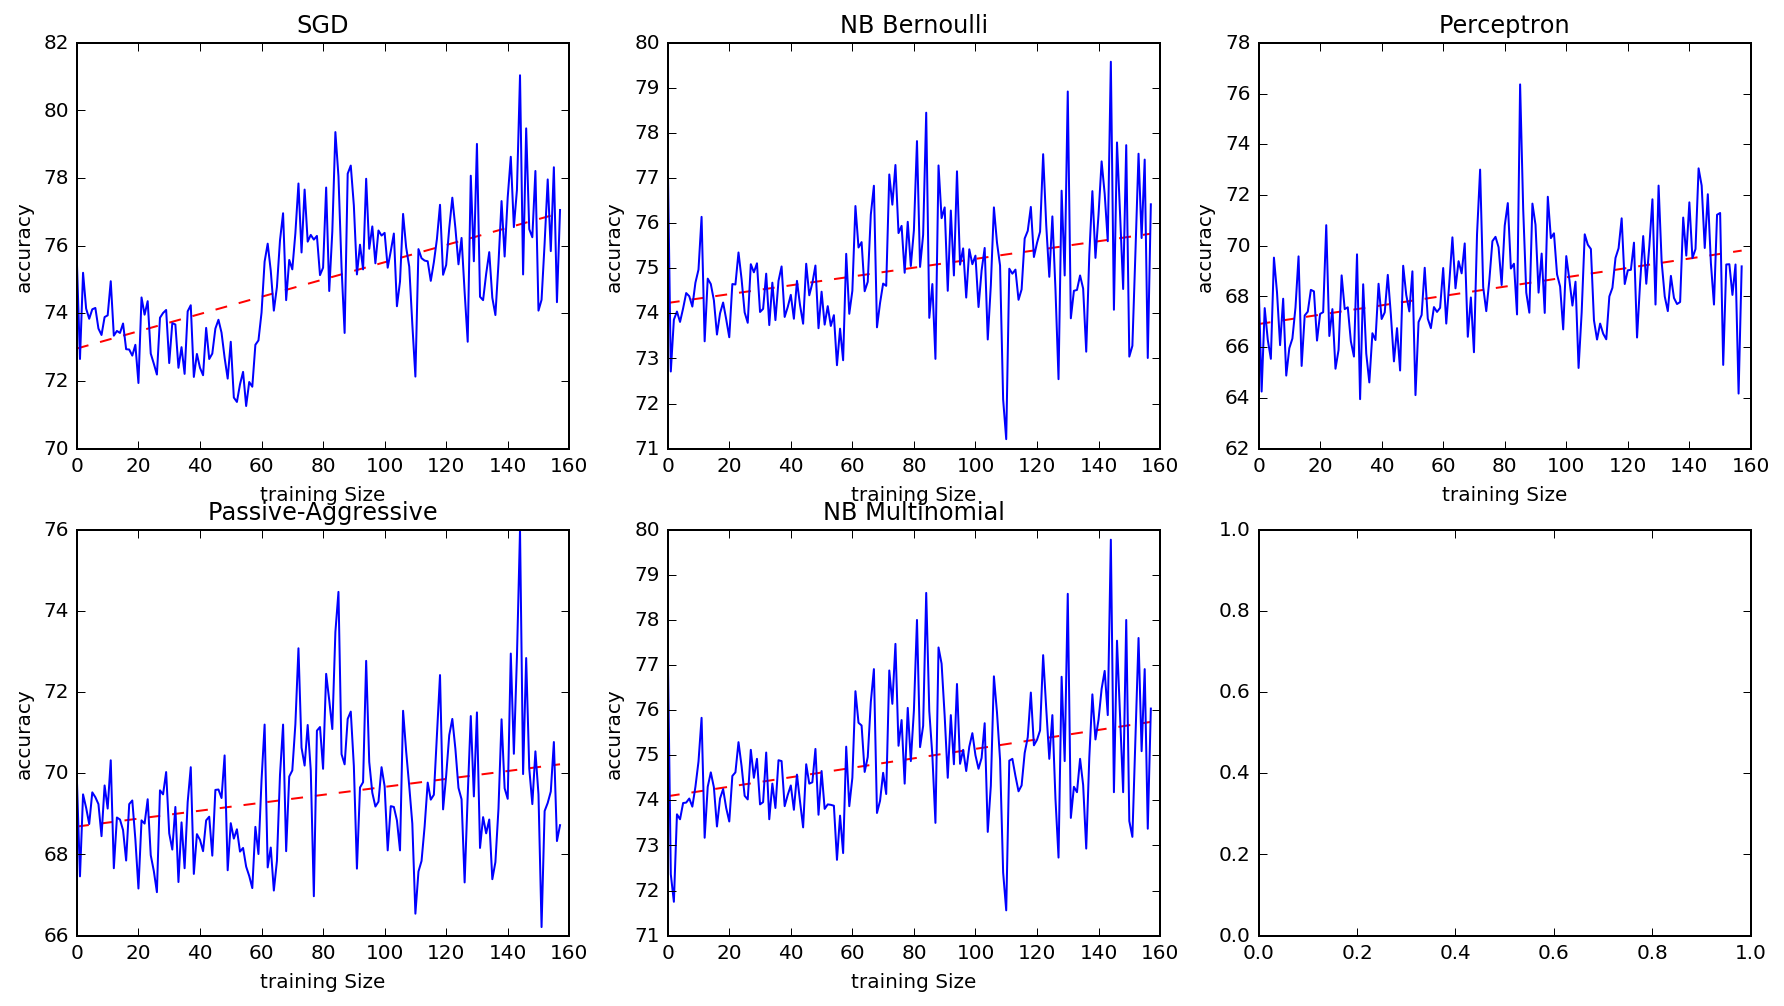

In [53]:
#print(classifier_information['SGD'])
#x = column(accuracy_info, 0)
#y = column(accuracy_info, 1)
#plt.plot(classifier_information['Preception'])
from sklearn.externals import joblib

joblib.dump(partial_fit_classifiers['SGD'], 'SGDClassifierOnSat.pkl')
joblib.dump(partial_fit_classifiers['Perceptron'], 'PerceptronClassifierOnSat.pkl')
joblib.dump(partial_fit_classifiers['NB Multinomial'], 'NBMClassifierOnSat.pkl')
joblib.dump(partial_fit_classifiers['Passive-Aggressive'], 'PAClassifierOnSat.pkl')
joblib.dump(partial_fit_classifiers['NB Bernoulli'], 'NBBClassifierOnSat.pkl')

x = range(0,158);
i = 0
fig, axes = plt.subplots(2, 3, squeeze=True, figsize=(15, 8))
for item in classifier_information:
    z = np.polyfit(x, classifier_information[item], 1)
    p = np.poly1d(z)
    axes[i//3,i%3].plot(x,p(x),"r--")
    axes[i//3,i%3].plot(x,classifier_information[item])
    axes[i//3,i%3].set_title(item)
    axes[i//3,i%3].set_ylabel("accuracy")
    axes[i//3,i%3].set_xlabel("training Size")
    i+=1


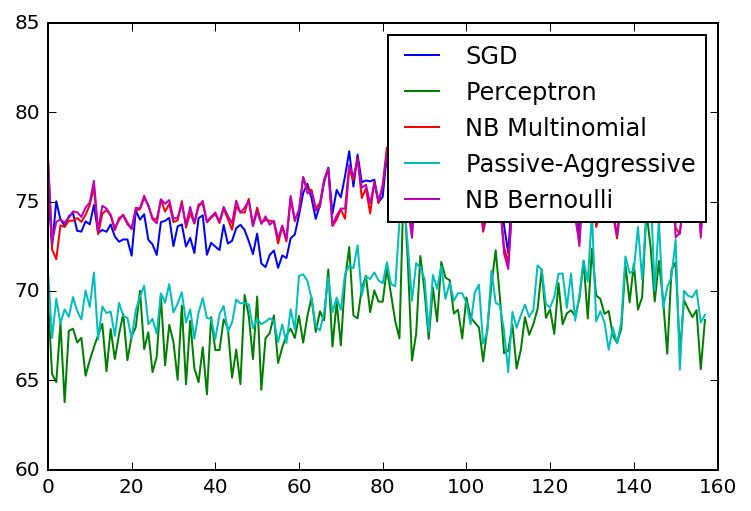

In [22]:
plt.figure()
plt.plot(classifier_information['SGD'])
plt.plot(classifier_information['Perceptron'])
plt.plot(classifier_information['NB Multinomial'])
plt.plot(classifier_information['Passive-Aggressive'])
plt.plot(classifier_information['NB Bernoulli'])
plt.legend(['SGD','Perceptron','NB Multinomial','Passive-Aggressive','NB Bernoulli'])

# Classifier For Amazon data 
** Feature extraction **

In [23]:
def compute_bag_of_words(text, stopwords, vocab=None):
    vectorizer = CountVectorizer(stop_words = stopwords,vocabulary=vocab)
    vectors = vectorizer.fit_transform(text)
    vocabulary = vectorizer.get_feature_names()
    return vectors, vocabulary

def column(matrix, i):
    return [row[i] for row in matrix]


text_amazon = column(Amazon_data,1)
Y_amazon = column(Amazon_data,0)


bow, vocab = compute_bag_of_words(text_amazon, stopwords.words())
KBestModel = SelectKBest( k=1000).fit(bow, Y_amazon) 
indices = KBestModel.get_support(True)
bow_transformed = KBestModel.transform(bow)
print("bow = {}".format(bow.shape))




bow = (31000, 43113)


In [24]:
from sklearn.externals import joblib

best_features_Amazon = np.array(vocab)[indices]
#print(best_features_Amazon)

file = open('Best_Features_Amazon.txt', 'w')
for word in best_features_Amazon:
    file.write("%s\n" % word)    


In [25]:
#input X is list of strings
def Transform_To_Input_Format_Amazon(X):
    with open('Best_Features_Amazon.txt') as f:
        features = f.readlines()
    features = [x.strip("\n") for x in features]
    X_transformed,vocab = compute_bag_of_words(X, stopwords.words(),features)
    return X_transformed
    
print(Transform_To_Input_Format_Amazon(["I am having a wonderfull day","Thank you very much"]))

  (0, 226)	1
  (1, 558)	1


** Classifier **

We train 6 different classifiers on each of the datasets to compare the performance of each classifier:
K-NN
SVM
Random Forest Classifier
Ridge Classifier
Bernoulli Naive Bayes
Mutlinomial Naive Bayes


In [91]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB




batches = []
Ys=[]
Y_amazon = np.array(Y_amazon)
y_all = np.unique(np.asarray(column(Amazon_data,0)))
print(y_all)
minibatch_size = 10000
start=0
# divide data into batches
while(start < bow.shape[0]):
    if(start + minibatch_size < bow.shape[0]):
        batch = bow[start:start+minibatch_size]
        Ys.append(Y_amazon[start:start+minibatch_size])
        batches.append(batch)
        start+=minibatch_size
    else:
        batch = bow[start:]
        Ys.append(Y_amazon[start:])
        batches.append(batch)
        start+=minibatch_size
    i += 1

        
#Classifiers      
partial_fit_Regressors = {
    'SGD Regressor':SGDRegressor(loss='squared_loss', penalty='l2', alpha=0.001, l1_ratio=0, 
                                 fit_intercept=True, n_iter=1000, shuffle=True, verbose=0, epsilon=0.01, random_state=None,
                                 learning_rate='invscaling', eta0=0.01, power_t=0.25, warm_start=False, average=False),
    'Passive-Aggressive Regressor' : PassiveAggressiveRegressor(),
     'SGD': SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
        eta0=0.0, fit_intercept=True, l1_ratio=0,
        learning_rate='optimal', loss='hinge', n_iter=300, n_jobs=1,
        penalty='l2', power_t=0.5, random_state=None, shuffle=True,
        verbose=0, warm_start=False),
    'Perceptron': Perceptron(penalty='l1', alpha=0.0001, fit_intercept=True, n_iter=50, 
                             shuffle=True, verbose=0, eta0=1.0, n_jobs=1, random_state=0, 
                             class_weight=None, warm_start=False),
    'NB Multinomial': MultinomialNB(alpha=1),
    'Passive-Aggressive': PassiveAggressiveClassifier(),
    'NB Bernoulli': BernoulliNB(alpha=0.01),
    
}
Regressors_information = {
    'SGD Regressor':[],
    'Passive-Aggressive Regressor':[],
    'SGD':[],
    'Perceptron': [],
    'NB Multinomial': [],
    'Passive-Aggressive': [],
    'NB Bernoulli':[],
}   
                   
cls_stats = {}       
                  

number_minibatch = len(batches)
    
print(number_minibatch)
FirstBatch = True
k = 0
# Main loop : iterate on mini-batches of examples
for i in range(number_minibatch):
    print("Batch number = {}".format(i))
    batch = batches[i]
    X = batch
    Y = Ys[i]
    #classifiers
    for cls_name, cls in partial_fit_Regressors.items():
        tick = time.time()
        #cross_validation
        kf = KFold(n_splits = 10)
        results =[]
        for train_index,test_index in kf.split(X):
            X_train,X_test = X[train_index],X[test_index]
            Y_train,Y_test = Y[train_index],Y[test_index]
            if(FirstBatch and cls_name != "SGD Regressor" and cls_name != "Passive-Aggressive Regressor"):
                cls.partial_fit(X_train, Y_train, classes = y_all)
                train_pred = cls.predict(X_test)
            elif(cls_name != "SGD Regressor" and cls_name != "Passive-Aggressive Regressor"):
                    cls.partial_fit(X_train, Y_train)
                    train_pred = cls.predict(X_test)
                    results.append(100*sklearn.metrics.accuracy_score(Y_test, train_pred))               
            else:
                Y_train = [int(x) for x in Y_train]
                Y_test = [int(x) for x in Y_test]
                cls.partial_fit(X_train, Y_train)
                train_pred = cls.predict(X_test)
                results.append(sklearn.metrics.mean_squared_error(Y_test, train_pred))
        Regressors_information[cls_name].append(np.mean(np.array(results)))
    FirstBatch = False

['1' '2' '3' '4' '5']
4
Batch number = 0
Batch number = 1
Batch number = 2
Batch number = 3


** Accuracy of Classifiers **


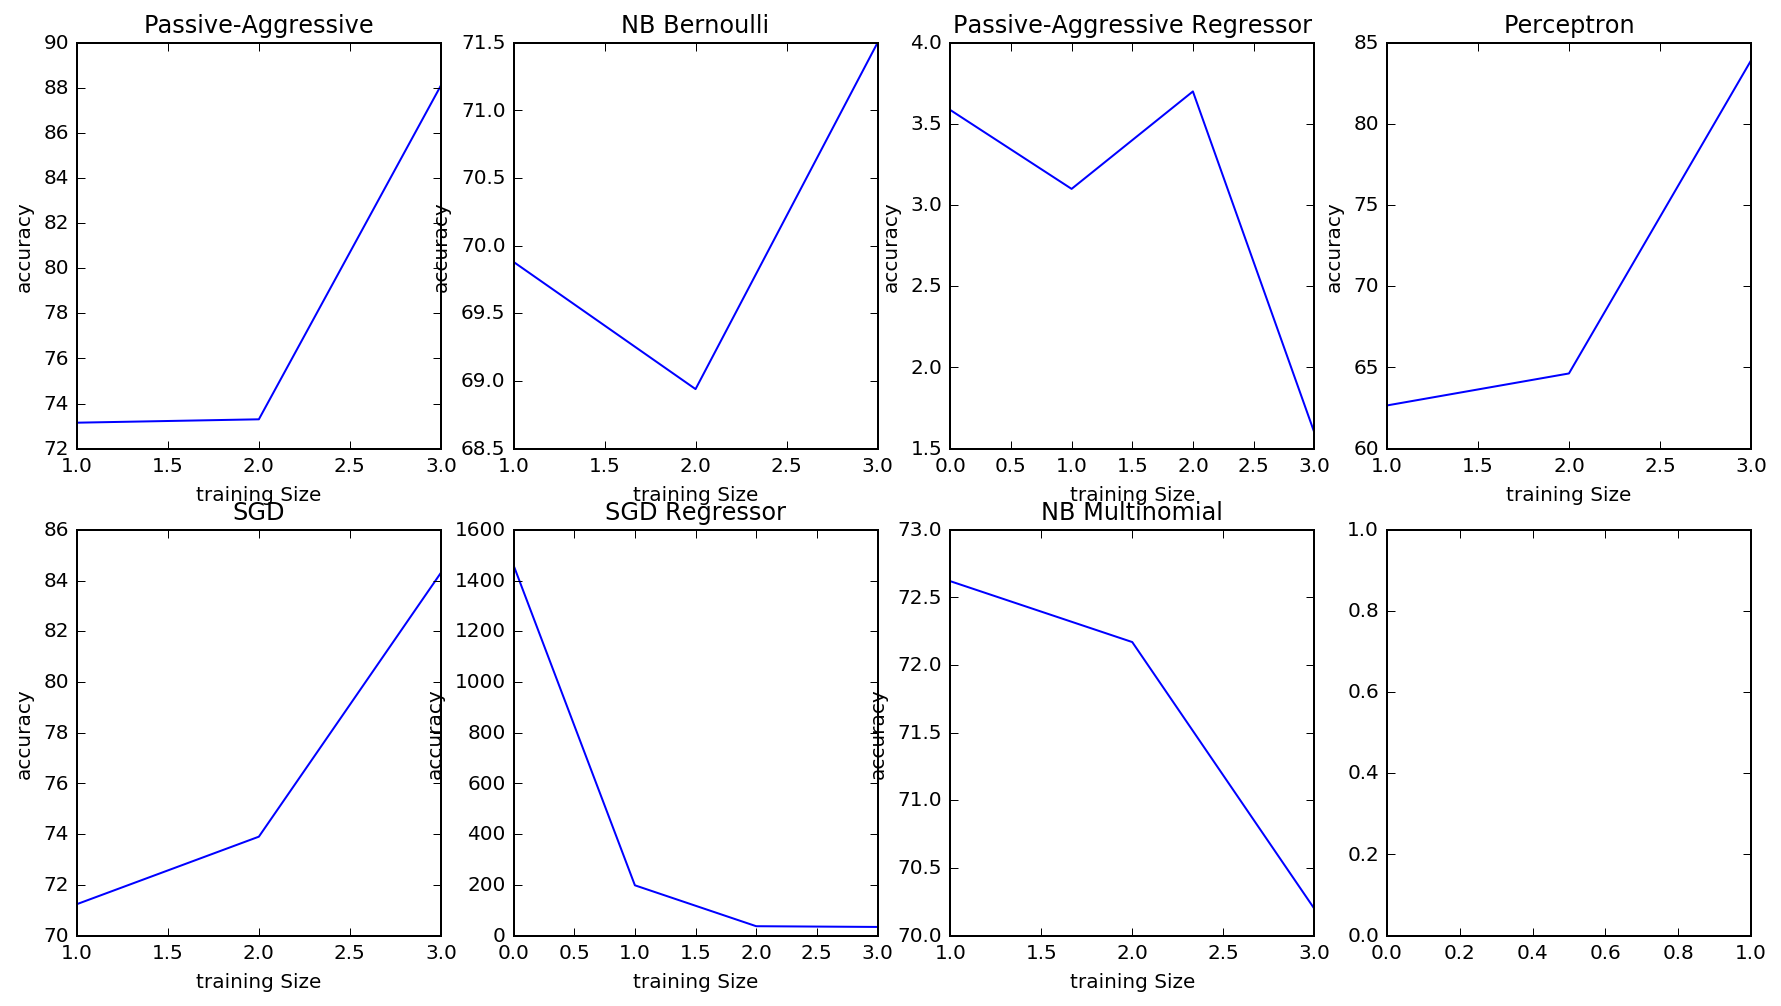

In [92]:
joblib.dump(partial_fit_Regressors['SGD'], 'SGDClassifierOnAmazon.pkl')
joblib.dump(partial_fit_Regressors['Perceptron'], 'PerceptronClassifierOnAmazon.pkl')
joblib.dump(partial_fit_Regressors['NB Multinomial'], 'NBMClassifierOnAmazon.pkl')
joblib.dump(partial_fit_Regressors['Passive-Aggressive'], 'PAClassifierOnAmazon.pkl')
joblib.dump(partial_fit_Regressors['NB Bernoulli'], 'NBBClassifierOnAmazon.pkl')
joblib.dump(partial_fit_Regressors['SGD Regressor'], 'SGDRegressorOnAmazon.pkl')
joblib.dump(partial_fit_Regressors['Passive-Aggressive Regressor'], 'Passive-AggressiveRegressorOnAmazon.pkl')


fig, axes = plt.subplots(2, 4, squeeze=True, figsize=(15, 8))
i = 0
for item in Regressors_information:
    axes[i//4,i%4].plot(Regressors_information[item])
    axes[i//4,i%4].set_title(item)
    axes[i//4,i%4].set_ylabel("accuracy")
    axes[i//4,i%4].set_xlabel("training Size")
    i+=1


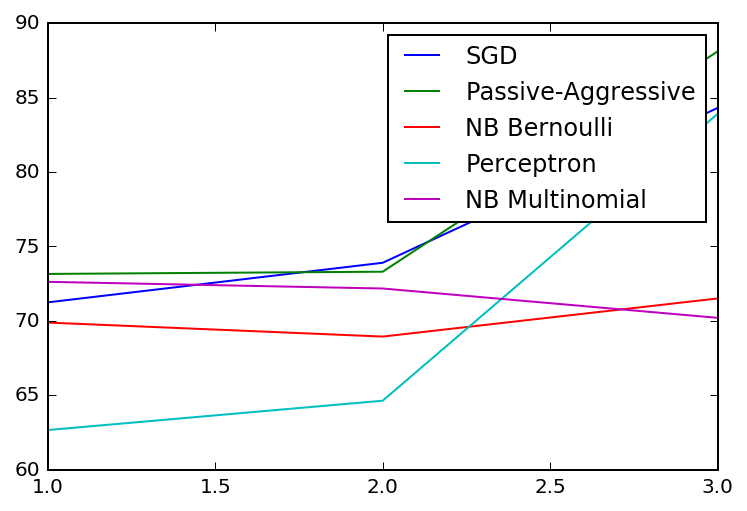

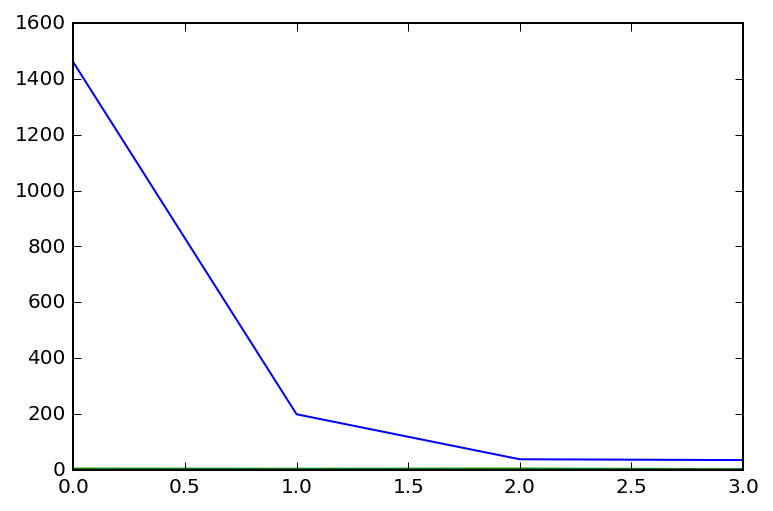

In [93]:
plt.plot(Regressors_information['SGD'])
plt.plot(Regressors_information['Passive-Aggressive'])
plt.plot(Regressors_information['NB Bernoulli'])
plt.plot(Regressors_information['Perceptron'])
plt.plot(Regressors_information['NB Multinomial'])
plt.legend(['SGD','Passive-Aggressive','NB Bernoulli','Perceptron','NB Multinomial'])

plt.figure()
plt.plot(Regressors_information['SGD Regressor'])
plt.plot(Regressors_information['Passive-Aggressive Regressor'])

# Political posts from Facebook and Twitter 

Goal: collect comments from political posts on Facebook and Twitter to evaluate the response of the audience (positive,negative).

In [ ]:
# Number of posts / tweets.
n = 20  

## Facebook

In [ ]:
import configparser

credentials = configparser.ConfigParser()
credentials.read('credentials.ini')
token = credentials.get('facebook', 'token')

import requests  
import facebook 
import pandas as pd
from IPython.display import display
import os

#testing with EPFL page, run it with the page of a politician's page
page = 'EPFL.ch'   #nb comments #nb likes #location  #comments likes 
postId= '107201356009441_1421993147863582'

In [ ]:
def userInformation(userId,user_serie):
    field = 'id, name,age_range,gender,location,political,religion,education'
    url = 'https://graph.facebook.com/{}?fields={}&access_token={}'.format(userId, field, token)
    #user_serie = {'user name':[], 'age':[], 'gender':[],'location':[],'political':[],'religion':[],'education':[]}

    user = requests.get(url).json()
    
    #print (user)

    user_serie['user name']=user['name']
    
    #try:
        #user_serie['age']=user['age_range']['min']
    #except KeyError :    
        #print('')
    #try:
        #user_serie['gender']=user['gender']
    #except KeyError:
        #print('')
    #try:
        #user_serie['location']=user['location']['name']
    #except KeyError:
        #print('')
    #try:
        #user_serie['political']=user['political']
    #except KeyError:
        #print('')
    #try:
        #user_serie['religion']=user['religion']
    #except KeyError:
        #print('')
    #try:
        #user_serie['education']=user['education']
    #except KeyError:
        #print('')
                                             
    return #[user_serie]
        

In [ ]:
#prepare data
from datetime import datetime

def convert_time(row):
    return datetime.strptime(row, '%Y-%m-%dT%H:%M:%S+0000')

In [ ]:
def lastPostsReactions(page,filename,n):
    fields = 'id,created_time,message,likes.limit(0).summary(1),comments.limits(0).summary(1)'
    url = 'https://graph.facebook.com/{}/posts?fields={}&access_token={}'.format(page, fields, token)

    fb = pd.DataFrame(columns=['post message','post id','post time','post likes','nb of comments','comment id', 'comment message', 'comment time', 'comment likes'])# 'user name']) #'age', 'gender','location','political','religion','education'])
    serie={'post message':[],'post id':[],'post time':[],'post likes':[],'nb of comments':[],'comment id':[],'comment message':[],'comment time':[], 'comment likes':[]}#,'user name':[]} # 'age':[], 'gender':[],'location':[],'political':[],'religion':[],'education':[]};
    
    i=0
    while i < n: #len(fb) < n:
    
        posts = requests.get(url).json()
        
        
        # extract information for each of the received post
        for post in posts['data']:
           
    
            try:
                # Only work with posts with text.
                post_message = post['message']
                try:
                    # Only work with posts with comments which have text.
                    nb_comments_per_post=post['comments']['summary']['total_count']
                
                    x= post['comments']['data'][0]['message'] #IndexError if no comment on the page, only work with posts
                    # which have at least 1 comment
                    i=i+1
                    j=0
                    for comment in range(0,nb_comments_per_post ):
                        j=j+1
                        comment_message=post['comments']['data'][comment]['message']
                        comment_message=comment_message.replace('\n',' ')
                        serie['comment message'] = comment_message
                        serie['comment time'] =  post['comments']['data'][comment]['created_time']
                        serie['comment likes'] =  post['comments']['data'][comment]['like_count']
                        serie['comment id']=post['comments']['data'][comment]['id']
                        
                        post_message=post['message']
                        post_message=post_message.replace('\n',' ')
                        serie['post message']=post_message
                        #print( post)
                        serie['post time']=post['created_time']
                        serie['post likes']=post['likes']['summary']['total_count']
                        serie['nb of comments']= post['comments']['summary']['total_count']
                        serie['post id']=post['id']
                        
                        
                        #userId=post['comments']['data'][comment]['from']['id']
                        #userInformation(userId, serie)
                    
                        fb = fb.append(serie , ignore_index=True)
                        #fb = fb.append(user_serie , ignore_index=True)                                        
                except IndexError or KeyError:
                    continue 
            except KeyError:
                continue       
        try:
        
            url = posts['paging']['next']
        except KeyError:
        
            break
            
        fb['comment message'] = fb['comment message'].astype(str)
        fb['post message'] = fb['post message'].astype(str)
        fb['comment likes']  = fb['comment likes'].astype(int)
        fb['post likes']  = fb['post likes'].astype(int)
        fb['nb of comments']  = fb['nb of comments'].astype(int)
        fb['post time'] = fb['post time'].apply(convert_time)
        fb['comment time'] = fb['comment time'].apply(convert_time)
        #fb['post id']= fb['post id'].astype(int)
        #fb['comment id']= fb['comment id'].astype(int)
        
        print("Number of posts: ",i)
        display(fb[:])
    
        folder = os.path.join('..', 'data', 'social_media')
        try:
            os.makedirs(folder)
        except FileExistsError:
            pass

        filename = os.path.join(folder, 'facebook'+ filename +'.sqlite')
        fb.to_sql('facebook', 'sqlite:///' + filename, if_exists='replace')
        
                               
                               
        return fb

In [ ]:
def postReactions (postId,filename):
    fields = 'id,created_time,message,likes.limit(0).summary(1),comments.limits(0).summary(1)'
    url = 'https://graph.facebook.com/{}?fields={}&access_token={}'.format(postId, fields, token)

    fb = pd.DataFrame(columns=['post message','post time','post likes','nb of comments', 'comment message', 'comment time', 'comment likes'])# 'user name']) #'age', 'gender','location','political','religion','education'])
    serie={'post message':[],'post time':[],'post likes':[],'nb of comments':[],'comment message':[],'comment time':[], 'comment likes':[]}#,'user name':[]} # 'age':[], 'gender':[],'location':[],'political':[],'religion':[],'education':[]};

    post = requests.get(url).json()
    try:
        # Only work with posts with text.
        post_message = post['message']
        try:
            # Only work with posts with comments which have text.
            nb_comments_per_post=post['comments']['summary']['total_count']
            #print(nb_comments_per_post,' comments')
                
            x= post['comments']['data'][0]['message'] #IndexError if no comment on the page, only work with posts
            # which have at least 1 comment
            for comment in range(0,nb_comments_per_post ):
                comment_message=post['comments']['data'][comment]['message']
                comment_message=comment_message.replace('\n',' ')
                serie['comment message'] = comment_message
                serie['comment time'] =  post['comments']['data'][comment]['created_time']
                serie['comment likes'] =  post['comments']['data'][comment]['like_count']
                        
                post_message=post['message']
                post_message=post_message.replace('\n',' ')
                serie['post message']=post_message
                #print( serie['post message'])
                serie['post time']=post['created_time']
                serie['post likes']=post['likes']['summary']['total_count']
                serie['nb of comments']= post['comments']['summary']['total_count']
                
                #userId=post['comments']['data'][comment]['from']['id']
                #userInformation(userId, serie)
                    
                fb = fb.append(serie , ignore_index=True)
                #fb = fb.append(user_serie , ignore_index=True)
                                        
        except IndexError or KeyError:
            print('')
    except KeyError:
        print('')

            
    fb['comment message'] = fb['comment message'].astype(str)
    fb['post message'] = fb['post message'].astype(str)
    fb['comment likes']  = fb['comment likes'].astype(int)
    fb['post likes']  = fb['post likes'].astype(int)
    fb['nb of comments']  = fb['nb of comments'].astype(int)
    fb['post time'] = fb['post time'].apply(convert_time)
    fb['comment time'] = fb['comment time'].apply(convert_time)
    
    display(fb[:])
    
    folder = os.path.join('..', 'data', 'social_media')
    try:
        os.makedirs(folder)
    except FileExistsError:
        pass

    filename = os.path.join(folder, 'facebook'+ filename +'.sqlite')
    fb.to_sql('facebook', 'sqlite:///' + filename, if_exists='replace')

    
    return fb

In [ ]:
#fb = lastPostsReactions(page,'EPFL',4000)
fb= postReactions(postId,'Martin')

# Twitter

In [ ]:

import tweepy  

auth = tweepy.OAuthHandler(credentials.get('twitter', 'consumer_key'), credentials.get('twitter', 'consumer_secret'))
auth.set_access_token(credentials.get('twitter', 'access_token'), credentials.get('twitter', 'access_secret'))
api = tweepy.API(auth)

n=20;

user = 'EPFL_en'
tweetId =808587395163635712

In [ ]:
def lastTweetsReactions(user):
    tw = pd.DataFrame(columns=['comment message', 'post message', 'post time', 'user name','location']) #'age', 'gender','location','political','religion','education'])
    serie={'comment message':[],'post message':[],'post time':[],'user name':[],'location':[]}# 'age':[], 'gender':[],'location':[],'political':[],'religion':[],'education':[]};

    i=0
    for tweet in tweepy.Cursor(api.user_timeline, screen_name=user).items(n):
        i=i+1
        print('tweet n°', i, ":",tweet.id_str)
        print(tweet.text)
        tweet.id_str
        username= tweet.user.name
        user_name="@" + username

        searched_tweets = api.search(user_name,since_id=tweet.id_str, count = 100)

        serie['post message']=tweet.text
        serie['post time']=tweet.created_at

        j=0
        for answer_tweet in searched_tweets:
            if (answer_tweet.in_reply_to_status_id == tweet.id_str):
                j=j+1
                serie['comment message']= answer_tweet.text
                serie['user name']=answer_tweet.user.name
                lat = answer_tweet.lat
                long = answer_tweet.long
                serie['location']=[lat, long]
        print("Number of responses:", j) 

        tw['comment message'] = tw['comment message'].astype(str)
        tw['post message'] = tw['post message'].astype(str)
        tw = tw.append(serie, ignore_index=True)
        
    return(tw)

In [ ]:
def tweetReactions(tweetId):
    tw = pd.DataFrame(columns=['comment message', 'post message', 'post time', 'user name','location']) #'age', 'gender','location','political','religion','education'])
    serie={'comment message':[],'post message':[],'post time':[],'user name':[],'location':[]}# 'age':[], 'gender':[],'location':[],'political':[],'religion':[],'education':[]};

    tweet=api.get_status(tweetId)
        
    print("tweet n°:",tweetId)
    
    username= tweet.user.screen_name
    user_name="@" + username
    print("username", user_name)
    print(tweet.text)

    searched_tweets = api.search(user_name, since_id=tweetId)
    #print(searched_tweets)

    serie['post message']=tweet.text
    serie['post time']=tweet.created_at

    j=0
    for answer_tweet in searched_tweets:
        #j=j+1
        #print(answer_tweet.text)
        if (answer_tweet.in_reply_to_status_id == tweetId):
            j=j+1
            print(answer_tweet.text)
            serie['comment message']= answer_tweet.text
            serie['user name']=answer_tweet.user.name
            #lat = api.get_status(answer_tweet.id).lat
            #long = answer_tweet.long
            #serie['location']=[lat, long]
            tw = tw.append(serie, ignore_index=True)
                
    print("Number of searched tweets:", j) 
    if(j==0):
        tw = tw.append(serie, ignore_index=True)
    tw['comment message'] = tw['comment message'].astype(str)
    tw['post message'] = tw['post message'].astype(str)
        
    return(tw)

In [ ]:
tw = tweetReactions(tweetId)
tw[:]

In [ ]:

from IPython.display import display
display(fb[:5])
display(tw[:5])

In [ ]:
import os

folder = os.path.join('..', 'data', 'social_media')
try:
    os.makedirs(folder)
except FileExistsError:
    pass

filename = os.path.join(folder, 'facebook.sqlite')
fb.to_sql('facebook', 'sqlite:///' + filename, if_exists='replace')

filename = os.path.join(folder, 'twitter.sqlite')
tw.to_sql('twitter', 'sqlite:///' + filename, if_exists='replace')